In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/Exp/Mutation/0.5/experiment1"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 471.26it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8445.84it/s]


absolute alignment indicates number: 178 label diff indicates number: 13 confidence diff indicates number: 12 high distance number: 8


In [3]:
import os
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
autoencoder = SimpleAutoencoder(512,512)
checkpoint = torch.load(os.path.join(TAR_PATH,"pre_autoencoder_init.npy"))
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

aaa


In [5]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.42/15 in epoch 200


1.4181

In [31]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features,val=0.15):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < val] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < val] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
        print(tar_diff,tar_border)
      
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_diff[i] <0.15 and tar_diff[i] <0.15:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
        return all_boundary_list,all_boundary_list_l,all_change,all_change_l,ref_diff,tar_diff
       
# all_boundary_list,all_boundary_list_l,all_change,all_change_l = eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

In [32]:
all_boundary_list,all_boundary_list_l,all_change,all_change_l,ref_border,tar_border = eval_boundary_align_sensitivity(autoencoder,tar_train_data, ref_train_data,0.15)  

123


100%|██████████| 250/250 [00:00<00:00, 8245.01it/s]

23



100%|██████████| 250/250 [00:00<00:00, 8333.21it/s]

[0.1737384  0.58281976 0.51345164 ... 0.44994348 0.5029102  0.2852087 ] [0.05 0.05 0.05 ... 0.05 0.05 0.05]
boundary sample preserving23/23
boundary change preserving266/555


In [32]:
len(all_boundary_list_l)

13

In [37]:
same_boundary = []
diff_boundary = []

for i in range(len(ref_top_classes)):
    if (tar_top_classes[i][0] == ref_top_classes[i][0] and tar_top_classes[i][1] == ref_top_classes[i][1]) or(tar_top_classes[i][1] == ref_top_classes[i][0] and tar_top_classes[i][0] == ref_top_classes[i][1]) :
        same_boundary.append(all_boundary_list_l[i])
    else:
        diff_boundary.append(all_boundary_list_l[i])



In [17]:
same_boundary

[38,
 48,
 285,
 396,
 397,
 618,
 646,
 798,
 1121,
 1134,
 1198,
 1647,
 1717,
 1886,
 1895,
 1897,
 1949,
 2010,
 2025,
 2186,
 2229,
 2416,
 2457,
 2521,
 2532,
 2668,
 2748,
 2884,
 3031,
 3046,
 3055,
 3265,
 3307,
 3320]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9383.86it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


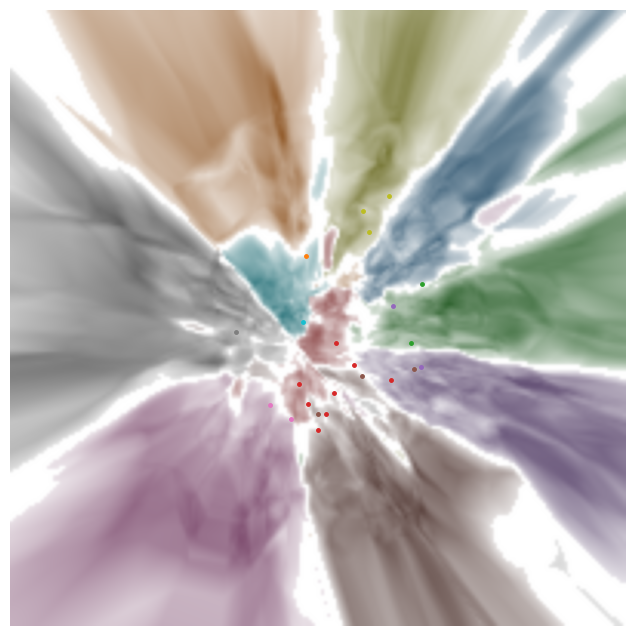

In [36]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[all_boundary_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [23]:
tar_border

array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05])

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 6700.17it/s]


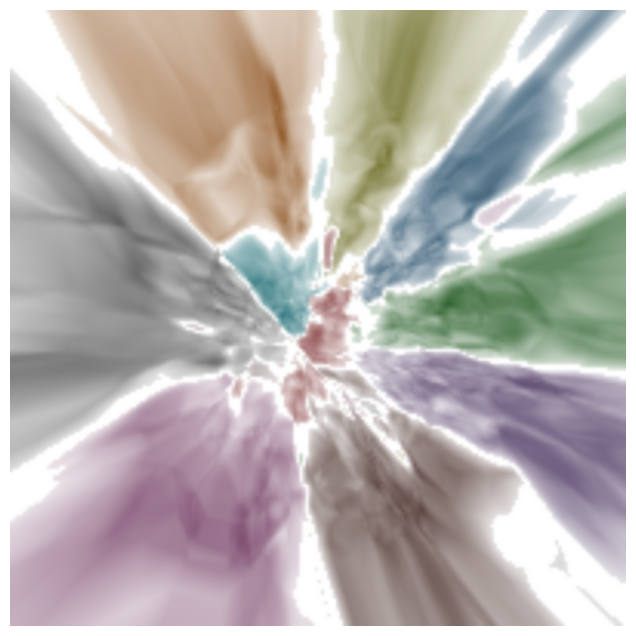

In [22]:
indicies = []
for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border[i] == 0 and tar_border[i] != 0:
                indicies.append(i)
  
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[indicies],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 3/3 [00:00<00:00, 9052.45it/s]


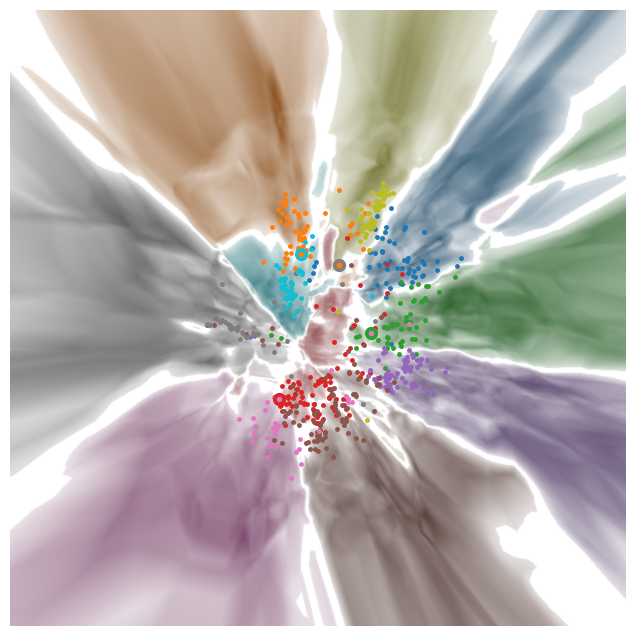

In [35]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 800,[all_change],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [35]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8591.58it/s]

#train# autoencoder PPR: 0.94 in epoch 200


0.94178

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3887.21it/s]


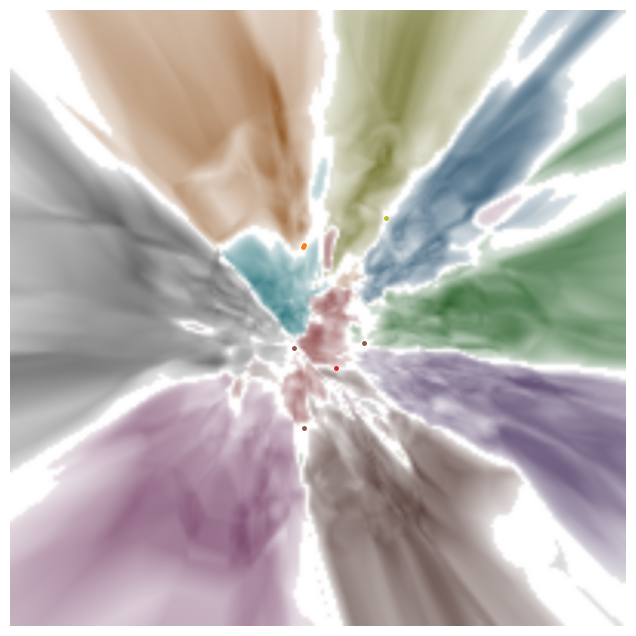

In [41]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[same_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


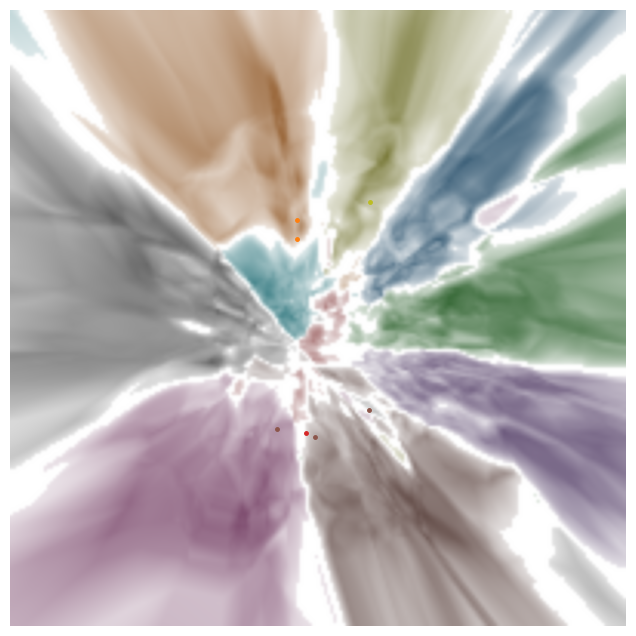

In [42]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[same_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5269.23it/s]


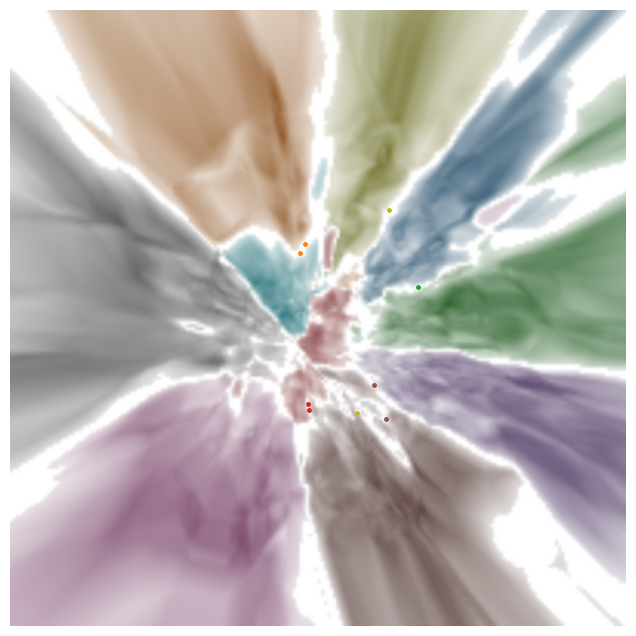

In [67]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[diff_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5562.74it/s]


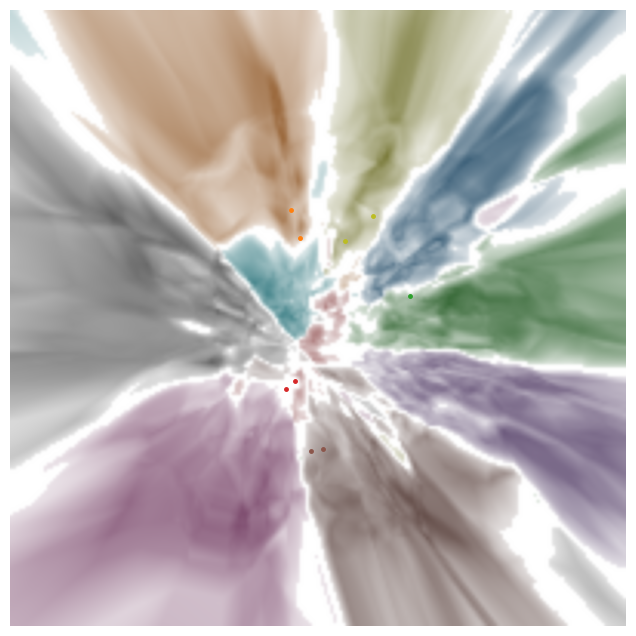

In [68]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[diff_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9117.16it/s]
../AlignVis_Visualizer/visualizer_boundary.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 1/1 [00:00<00:00, 4076.10it/s]


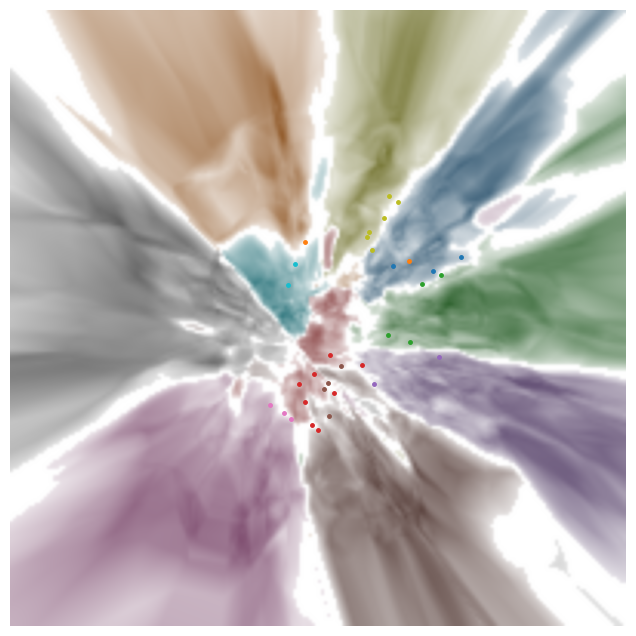

In [52]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")


from AlignVis_Visualizer.visualizer_boundary import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[same_boundary],'tab10')
# from representationTrans.visualizer import visualizer
# vis = visualizer(tar_provider, I,I, np.dot(tar_provider.test_representation(200), I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))